In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import random
import shutil, sys
import pandas as pd

plt.ion()

In [2]:
#data augmentation apenas para o treinamento
#normalization para a validaa

data_transforms = {'train': transforms.Compose(
                    [transforms.RandomResizedCrop(224),
                    #transforms.RandomRotation(degrees=(-5, 5)),
                    #transforms.ColorJitter(brightness=.02),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ]),
                    'val': transforms.Compose([transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
                  }

In [93]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
root = data_dir
data_dir = '/home/jimi/dissertacao/covid19/datasets/dataset_bal/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'


normal_xray = get_dataset(normal_dir, 'normal')
pneumonia_xray = get_dataset(pneumonia_dir, 'pneumonia')

#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
# metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
# srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
# df=pd.read_csv(metadata_path)
# covid_patients=df['finding']=='COVID-19'
# PA=df['view']=='PA'
# PA_covid=df[covid_patients & PA]
covid_xray = get_dataset(covid_dir, 'covid')
#print(len(covid_xray), covid_xray[0:5])

random.shuffle(normal_xray)
random.shuffle(pneumonia_xray)
random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray)) -1
dataset = normal_xray + pneumonia_xray + covid_xray
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

print (X)
X.shape
print('----------')
print (y)
y.shape

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42) #pega % do treino e separa para teste/
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = root+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


min_size = 504
1069    /home/jimi/dissertacao/covid19/datasets/datase...
2747    /home/jimi/dissertacao/covid19/datasets/datase...
863     /home/jimi/dissertacao/covid19/datasets/datase...
2102    /home/jimi/dissertacao/covid19/datasets/datase...
266     /home/jimi/dissertacao/covid19/datasets/datase...
                              ...                        
3069    /home/jimi/dissertacao/covid19/datasets/datase...
1801    /home/jimi/dissertacao/covid19/datasets/datase...
1947    /home/jimi/dissertacao/covid19/datasets/datase...
39      /home/jimi/dissertacao/covid19/datasets/datase...
2405    /home/jimi/dissertacao/covid19/datasets/datase...
Name: X, Length: 3191, dtype: object
----------
1069    pneumonia
2747    pneumonia
863     pneumonia
2102       normal
266     pneumonia
          ...    
3069    pneumonia
1801       normal
1947    pneumonia
39      pneumonia
2405    pneumonia
Name: y, Length: 3191, dtype: object
Classes: ['pneumonia' 'normal' 'covid']
------------------------

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (495).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (232).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1048).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (910).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (807).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1197).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/d

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (115).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (725).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (751).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1147).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (797).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/459.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/no

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1333).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (267).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (752).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (660).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (231).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (626).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissert

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (306).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (686).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (222).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/227.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1075).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (190).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/data

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1181).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1083).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (249).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (506).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1149).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (619).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/datase

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (486).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1311).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1294).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/336.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (972).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (101).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/n

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (360).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1206).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1162).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1212).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (810).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (677).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/datase

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (502).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1082).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (439).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (717).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (736).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (410).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (224).p

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/461.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/117.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/489.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1289).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1070).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1178).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1283).png /home/jimi/dissertacao/covid19/datasets

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (192).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/178.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1142).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (642).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/125.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/15.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (847).png /home/jimi/disse

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/389.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (32).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1308).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/200.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (932).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (91).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (818).png /home/jimi/

In [3]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/dataset_bal/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)
print("-"*20)
print('Train, test, validation')
print("-"*20)
print("len_train_dir : ", len_train_dir)
print("len_test_dir : ", len_test_dir)
print("len_val_dir : ", len_val_dir)


Files per classes
----------------------------------------
normal :  505
pneumonia :  505
covid :  505
--------------------
Train, test, validation
--------------------
len_train_dir :  969
len_test_dir :  303
len_val_dir :  243


In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def imshow(inp, title=None):
    """Imshow for tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.585, 0.556, 0.506])
    std = np.array([0.329, 0.324, 0.325])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pausa um pouco para que os gráficos sejam atualizados

In [6]:
#pega o batch de treinamento
inputs, classes = next(iter(dataloaders['train']))

In [7]:
#grid from batch
out = torchvision.utils.make_grid(inputs)

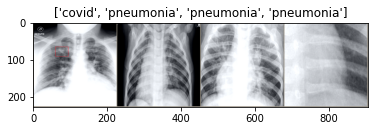

In [8]:
imshow(out, title=[class_names[x] for x in classes])

In [12]:
#traing
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range (num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*20)
        
        #cada epoca tem uma fase de treino e validação
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #seta o moledo para treinar
            else:
                model.eval() #seta para validação
                
            running_loss = 0.0
            running_corrects = 0
            
            # Itera sobre os dados
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero gradientes
                optimizer.zero_grad()
                
                #forward
                #rastrea o historico se apenas no treino
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimizer only se estiver no treino
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                #statistc
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #copia para o modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #carrega o modelo com os melhores pesos
    model.load_state_dict(best_model_wts)
    
    return model

In [13]:
# Função genérica para mostrar as predições das imagens
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(1024, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.0213 Acc: 0.5067
val Loss: 0.8582 Acc: 0.7531

Epoch 1/99
--------------------
train Loss: 0.9209 Acc: 0.6305
val Loss: 0.7356 Acc: 0.9095

Epoch 2/99
--------------------
train Loss: 0.8561 Acc: 0.7162
val Loss: 0.6873 Acc: 0.9177

Epoch 3/99
--------------------
train Loss: 0.8435 Acc: 0.7203
val Loss: 0.6663 Acc: 0.9218

Epoch 4/99
--------------------
train Loss: 0.8124 Acc: 0.7544
val Loss: 0.6519 Acc: 0.9259

Epoch 5/99
--------------------
train Loss: 0.8387 Acc: 0.7131
val Loss: 0.6608 Acc: 0.9136

Epoch 6/99
--------------------
train Loss: 0.8049 Acc: 0.7461
val Loss: 0.6594 Acc: 0.9053

Epoch 7/99
--------------------
train Loss: 0.7889 Acc: 0.7647
val Loss: 0.6338 Acc: 0.9300

Epoch 8/99
--------------------
train Loss: 0.7884 Acc: 0.7657
val Loss: 0.6506 Acc: 0.9136

Epoch 9/99
--------------------
train Loss: 0.8162 Acc: 0.7337
val Loss: 0.6416 Acc: 0.9177

Epoch 10/99
--------------------
train Loss: 0.8137 Acc: 0.7430
val Lo

train Loss: 0.7815 Acc: 0.7699
val Loss: 0.6438 Acc: 0.9136

Epoch 88/99
--------------------
train Loss: 0.8041 Acc: 0.7472
val Loss: 0.6291 Acc: 0.9342

Epoch 89/99
--------------------
train Loss: 0.7874 Acc: 0.7585
val Loss: 0.6413 Acc: 0.9177

Epoch 90/99
--------------------
train Loss: 0.7811 Acc: 0.7771
val Loss: 0.6499 Acc: 0.9095

Epoch 91/99
--------------------
train Loss: 0.7803 Acc: 0.7657
val Loss: 0.6377 Acc: 0.9218

Epoch 92/99
--------------------
train Loss: 0.7932 Acc: 0.7575
val Loss: 0.6436 Acc: 0.9177

Epoch 93/99
--------------------
train Loss: 0.7753 Acc: 0.7771
val Loss: 0.6403 Acc: 0.9259

Epoch 94/99
--------------------
train Loss: 0.7721 Acc: 0.7895
val Loss: 0.6371 Acc: 0.9218

Epoch 95/99
--------------------
train Loss: 0.7949 Acc: 0.7575
val Loss: 0.6305 Acc: 0.9300

Epoch 96/99
--------------------
train Loss: 0.7957 Acc: 0.7606
val Loss: 0.6388 Acc: 0.9342

Epoch 97/99
--------------------
train Loss: 0.7929 Acc: 0.7647
val Loss: 0.6326 Acc: 0.9259


In [16]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(1024, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.2998 Acc: 0.5439
val Loss: 0.6310 Acc: 0.7737

Epoch 1/99
--------------------
train Loss: 0.7273 Acc: 0.6997
val Loss: 0.3807 Acc: 0.8765

Epoch 2/99
--------------------
train Loss: 0.7205 Acc: 0.7224
val Loss: 0.2519 Acc: 0.9136

Epoch 3/99
--------------------
train Loss: 0.6138 Acc: 0.7606
val Loss: 0.5023 Acc: 0.8395

Epoch 4/99
--------------------
train Loss: 0.6806 Acc: 0.7503
val Loss: 0.2668 Acc: 0.9095

Epoch 5/99
--------------------
train Loss: 0.5543 Acc: 0.7750
val Loss: 0.2456 Acc: 0.9342

Epoch 6/99
--------------------
train Loss: 0.6651 Acc: 0.7575
val Loss: 0.5114 Acc: 0.8477

Epoch 7/99
--------------------
train Loss: 0.4931 Acc: 0.8070
val Loss: 0.2872 Acc: 0.9259

Epoch 8/99
--------------------
train Loss: 0.4824 Acc: 0.8101
val Loss: 0.2817 Acc: 0.9259

Epoch 9/99
--------------------
train Loss: 0.4441 Acc: 0.8215
val Loss: 0.2891 Acc: 0.9300

Epoch 10/99
--------------------
train Loss: 0.5295 Acc: 0.7833
val Lo

train Loss: 0.4375 Acc: 0.8266
val Loss: 0.2723 Acc: 0.9300

Epoch 88/99
--------------------
train Loss: 0.4752 Acc: 0.8163
val Loss: 0.2642 Acc: 0.9177

Epoch 89/99
--------------------
train Loss: 0.5060 Acc: 0.8029
val Loss: 0.2568 Acc: 0.9383

Epoch 90/99
--------------------
train Loss: 0.4587 Acc: 0.8297
val Loss: 0.2548 Acc: 0.9218

Epoch 91/99
--------------------
train Loss: 0.4781 Acc: 0.8194
val Loss: 0.2406 Acc: 0.9424

Epoch 92/99
--------------------
train Loss: 0.4528 Acc: 0.8132
val Loss: 0.2637 Acc: 0.9259

Epoch 93/99
--------------------
train Loss: 0.4854 Acc: 0.8008
val Loss: 0.2715 Acc: 0.9259

Epoch 94/99
--------------------
train Loss: 0.4896 Acc: 0.8050
val Loss: 0.2356 Acc: 0.9300

Epoch 95/99
--------------------
train Loss: 0.4571 Acc: 0.8132
val Loss: 0.2993 Acc: 0.9218

Epoch 96/99
--------------------
train Loss: 0.4665 Acc: 0.8153
val Loss: 0.2617 Acc: 0.9342

Epoch 97/99
--------------------
train Loss: 0.4713 Acc: 0.8173
val Loss: 0.2963 Acc: 0.9300


In [18]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(1024, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.2202 Acc: 0.5676
val Loss: 0.4952 Acc: 0.8148

Epoch 1/99
--------------------
train Loss: 0.7139 Acc: 0.6987
val Loss: 0.4155 Acc: 0.8189

Epoch 2/99
--------------------
train Loss: 0.6729 Acc: 0.7286
val Loss: 0.2339 Acc: 0.9383

Epoch 3/99
--------------------
train Loss: 0.6803 Acc: 0.7307
val Loss: 0.6873 Acc: 0.7243

Epoch 4/99
--------------------
train Loss: 0.5170 Acc: 0.8029
val Loss: 0.2324 Acc: 0.9177

Epoch 5/99
--------------------
train Loss: 0.5932 Acc: 0.7554
val Loss: 0.1963 Acc: 0.9383

Epoch 6/99
--------------------
train Loss: 0.5788 Acc: 0.7853
val Loss: 0.2466 Acc: 0.9136

Epoch 7/99
--------------------
train Loss: 0.4974 Acc: 0.8060
val Loss: 0.2114 Acc: 0.9424

Epoch 8/99
--------------------
train Loss: 0.4565 Acc: 0.8369
val Loss: 0.2601 Acc: 0.9218

Epoch 9/99
--------------------
train Loss: 0.4831 Acc: 0.8091
val Loss: 0.2588 Acc: 0.9300

Epoch 10/99
--------------------
train Loss: 0.4554 Acc: 0.8132
val Lo

train Loss: 0.4513 Acc: 0.8359
val Loss: 0.2700 Acc: 0.9095

Epoch 88/99
--------------------
train Loss: 0.4450 Acc: 0.8246
val Loss: 0.2051 Acc: 0.9177

Epoch 89/99
--------------------
train Loss: 0.4681 Acc: 0.8091
val Loss: 0.1892 Acc: 0.9424

Epoch 90/99
--------------------
train Loss: 0.4476 Acc: 0.8173
val Loss: 0.3481 Acc: 0.8272

Epoch 91/99
--------------------
train Loss: 0.4309 Acc: 0.8318
val Loss: 0.1997 Acc: 0.9424

Epoch 92/99
--------------------
train Loss: 0.4263 Acc: 0.8215
val Loss: 0.1906 Acc: 0.9465

Epoch 93/99
--------------------
train Loss: 0.4672 Acc: 0.8194
val Loss: 0.2185 Acc: 0.9177

Epoch 94/99
--------------------
train Loss: 0.4611 Acc: 0.8225
val Loss: 0.1833 Acc: 0.9424

Epoch 95/99
--------------------
train Loss: 0.4293 Acc: 0.8328
val Loss: 0.1941 Acc: 0.9506

Epoch 96/99
--------------------
train Loss: 0.4697 Acc: 0.8215
val Loss: 0.2348 Acc: 0.9300

Epoch 97/99
--------------------
train Loss: 0.4543 Acc: 0.8277
val Loss: 0.2312 Acc: 0.9300


In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.0425 Acc: 0.4923
val Loss: 0.9345 Acc: 0.6173

Epoch 1/99
--------------------
train Loss: 0.9574 Acc: 0.5913
val Loss: 0.8263 Acc: 0.7119

Epoch 2/99
--------------------
train Loss: 0.8981 Acc: 0.6708
val Loss: 0.7531 Acc: 0.8189

Epoch 3/99
--------------------
train Loss: 0.8715 Acc: 0.6966
val Loss: 0.6888 Acc: 0.9095

Epoch 4/99
--------------------
train Loss: 0.8721 Acc: 0.6811
val Loss: 0.6867 Acc: 0.9095

Epoch 5/99
--------------------
train Loss: 0.8480 Acc: 0.7007
val Loss: 0.7079 Acc: 0.8395

Epoch 6/99
--------------------
train Loss: 0.8635 Acc: 0.6801
val Loss: 0.6447 Acc: 0.9177

Epoch 7/99
--------------------
train Loss: 0.8035 Acc: 0.7523
val Loss: 0.6711 Acc: 0.8807

Epoch 8/99
--------------------
train Loss: 0.7992 Acc: 0.7595
val Loss: 0.6495 Acc: 0.9300

Epoch 9/99
--------------------
train Loss: 0.8121 Acc: 0.7317
val Loss: 0.6530 Acc: 0.9136

Epoch 10/99
--------------------
train Loss: 0.8120 Acc: 0.7482
val Lo

train Loss: 0.7942 Acc: 0.7781
val Loss: 0.6335 Acc: 0.9259

Epoch 88/99
--------------------
train Loss: 0.8027 Acc: 0.7451
val Loss: 0.6756 Acc: 0.8683

Epoch 89/99
--------------------
train Loss: 0.8065 Acc: 0.7503
val Loss: 0.6651 Acc: 0.8889

Epoch 90/99
--------------------
train Loss: 0.7881 Acc: 0.7740
val Loss: 0.6445 Acc: 0.9218

Epoch 91/99
--------------------
train Loss: 0.7958 Acc: 0.7585
val Loss: 0.6544 Acc: 0.9053

Epoch 92/99
--------------------
train Loss: 0.8167 Acc: 0.7379
val Loss: 0.6732 Acc: 0.8724

Epoch 93/99
--------------------
train Loss: 0.8150 Acc: 0.7368
val Loss: 0.6451 Acc: 0.9136

Epoch 94/99
--------------------
train Loss: 0.8018 Acc: 0.7564
val Loss: 0.6376 Acc: 0.9342

Epoch 95/99
--------------------
train Loss: 0.7874 Acc: 0.7781
val Loss: 0.6469 Acc: 0.9218

Epoch 96/99
--------------------
train Loss: 0.7915 Acc: 0.7719
val Loss: 0.6576 Acc: 0.9053

Epoch 97/99
--------------------
train Loss: 0.7767 Acc: 0.7792
val Loss: 0.6549 Acc: 0.9177


In [21]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(512, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.3099 Acc: 0.5521
val Loss: 0.3788 Acc: 0.8765

Epoch 1/99
--------------------
train Loss: 0.7594 Acc: 0.6852
val Loss: 0.3598 Acc: 0.9053

Epoch 2/99
--------------------
train Loss: 0.7037 Acc: 0.7224
val Loss: 0.5531 Acc: 0.8107

Epoch 3/99
--------------------
train Loss: 0.7002 Acc: 0.7399
val Loss: 0.3349 Acc: 0.8807

Epoch 4/99
--------------------
train Loss: 0.6076 Acc: 0.7678
val Loss: 0.3729 Acc: 0.8807

Epoch 5/99
--------------------
train Loss: 0.7485 Acc: 0.7110
val Loss: 0.2805 Acc: 0.9424

Epoch 6/99
--------------------
train Loss: 0.6649 Acc: 0.7472
val Loss: 0.3092 Acc: 0.9012

Epoch 7/99
--------------------
train Loss: 0.5135 Acc: 0.8070
val Loss: 0.2451 Acc: 0.9465

Epoch 8/99
--------------------
train Loss: 0.5335 Acc: 0.7792
val Loss: 0.2332 Acc: 0.9383

Epoch 9/99
--------------------
train Loss: 0.5150 Acc: 0.7936
val Loss: 0.2505 Acc: 0.9259

Epoch 10/99
--------------------
train Loss: 0.5127 Acc: 0.8019
val Lo

train Loss: 0.5012 Acc: 0.7988
val Loss: 0.2215 Acc: 0.9259

Epoch 88/99
--------------------
train Loss: 0.4701 Acc: 0.8163
val Loss: 0.3186 Acc: 0.9012

Epoch 89/99
--------------------
train Loss: 0.4789 Acc: 0.8019
val Loss: 0.2306 Acc: 0.9300

Epoch 90/99
--------------------
train Loss: 0.4600 Acc: 0.8266
val Loss: 0.2097 Acc: 0.9547

Epoch 91/99
--------------------
train Loss: 0.5097 Acc: 0.7977
val Loss: 0.2238 Acc: 0.9383

Epoch 92/99
--------------------
train Loss: 0.4582 Acc: 0.8194
val Loss: 0.2384 Acc: 0.9424

Epoch 93/99
--------------------
train Loss: 0.4354 Acc: 0.8132
val Loss: 0.2530 Acc: 0.9424

Epoch 94/99
--------------------
train Loss: 0.5248 Acc: 0.7812
val Loss: 0.2570 Acc: 0.9259

Epoch 95/99
--------------------
train Loss: 0.4529 Acc: 0.8204
val Loss: 0.2426 Acc: 0.9259

Epoch 96/99
--------------------
train Loss: 0.4878 Acc: 0.7967
val Loss: 0.2212 Acc: 0.9342

Epoch 97/99
--------------------
train Loss: 0.4894 Acc: 0.8050
val Loss: 0.2288 Acc: 0.9465


In [22]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(512, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.2753 Acc: 0.5717
val Loss: 0.3785 Acc: 0.8477

Epoch 1/99
--------------------
train Loss: 0.7558 Acc: 0.6821
val Loss: 0.3520 Acc: 0.8395

Epoch 2/99
--------------------
train Loss: 0.6075 Acc: 0.7482
val Loss: 0.2188 Acc: 0.9342

Epoch 3/99
--------------------
train Loss: 0.6086 Acc: 0.7399
val Loss: 0.3533 Acc: 0.8807

Epoch 4/99
--------------------
train Loss: 0.5843 Acc: 0.7761
val Loss: 0.2305 Acc: 0.9300

Epoch 5/99
--------------------
train Loss: 0.5405 Acc: 0.7761
val Loss: 0.1911 Acc: 0.9465

Epoch 6/99
--------------------
train Loss: 0.6238 Acc: 0.7678
val Loss: 0.2454 Acc: 0.9259

Epoch 7/99
--------------------
train Loss: 0.4739 Acc: 0.8204
val Loss: 0.1845 Acc: 0.9342

Epoch 8/99
--------------------
train Loss: 0.5020 Acc: 0.7967
val Loss: 0.2197 Acc: 0.9465

Epoch 9/99
--------------------
train Loss: 0.4857 Acc: 0.8132
val Loss: 0.2486 Acc: 0.8889

Epoch 10/99
--------------------
train Loss: 0.4997 Acc: 0.7967
val Lo

train Loss: 0.4676 Acc: 0.8215
val Loss: 0.2298 Acc: 0.9300

Epoch 88/99
--------------------
train Loss: 0.4766 Acc: 0.8091
val Loss: 0.2045 Acc: 0.9177

Epoch 89/99
--------------------
train Loss: 0.4377 Acc: 0.8390
val Loss: 0.2055 Acc: 0.9465

Epoch 90/99
--------------------
train Loss: 0.4492 Acc: 0.8277
val Loss: 0.2662 Acc: 0.9259

Epoch 91/99
--------------------
train Loss: 0.4240 Acc: 0.8246
val Loss: 0.1950 Acc: 0.9465

Epoch 92/99
--------------------
train Loss: 0.4828 Acc: 0.8163
val Loss: 0.1986 Acc: 0.9506

Epoch 93/99
--------------------
train Loss: 0.4624 Acc: 0.8111
val Loss: 0.1771 Acc: 0.9547

Epoch 94/99
--------------------
train Loss: 0.4437 Acc: 0.8308
val Loss: 0.2656 Acc: 0.9053

Epoch 95/99
--------------------
train Loss: 0.4703 Acc: 0.8328
val Loss: 0.2091 Acc: 0.9424

Epoch 96/99
--------------------
train Loss: 0.4673 Acc: 0.8091
val Loss: 0.2253 Acc: 0.9383

Epoch 97/99
--------------------
train Loss: 0.4239 Acc: 0.8277
val Loss: 0.2162 Acc: 0.9177


In [ ]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 64),
                                      nn.ReLU(),
                                      nn.Dropout(0.3),
                                      nn.Linear(64, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.2070 Acc: 0.5655
val Loss: 0.3683 Acc: 0.8683

Epoch 1/99
--------------------
train Loss: 0.7515 Acc: 0.6935
val Loss: 0.5275 Acc: 0.8066

Epoch 2/99
--------------------
train Loss: 0.6768 Acc: 0.7368
val Loss: 0.2856 Acc: 0.9177

Epoch 3/99
--------------------
train Loss: 0.6457 Acc: 0.7368
val Loss: 0.2682 Acc: 0.9218

Epoch 4/99
--------------------
train Loss: 0.5189 Acc: 0.7977
val Loss: 0.2988 Acc: 0.9095

Epoch 5/99
--------------------
train Loss: 0.6052 Acc: 0.7709
val Loss: 0.1675 Acc: 0.9465

Epoch 6/99
--------------------
train Loss: 0.6014 Acc: 0.7688
val Loss: 0.2069 Acc: 0.9506

Epoch 7/99
--------------------
train Loss: 0.4909 Acc: 0.8173
val Loss: 0.1945 Acc: 0.9342

Epoch 8/99
--------------------
train Loss: 0.4797 Acc: 0.8122
val Loss: 0.2095 Acc: 0.9300

Epoch 9/99
--------------------
train Loss: 0.4684 Acc: 0.8297
val Loss: 0.2546 Acc: 0.9012

Epoch 10/99
--------------------
train Loss: 0.4620 Acc: 0.8132
val Lo

In [ ]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 1024),
                                            nn.ReLU(),
                                            nn.Linear(num_ftrs, 512),
                                            nn.ReLU(),
                                            nn.Linear(num_ftrs, 256),
                                            nn.ReLU(),
                                            nn.Dropout(0.5),
                                            nn.Linear(num_ftrs, 128),
                                            nn.ReLU(),
                                            nn.Linear(num_ftrs, 64),
                                            nn.ReLU(),
                                            nn.Dropout(0.5),
                                            nn.Linear(64, 3),
                                            nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [ ]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(128, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [ ]:
model_conv = torchvision.models.inception_v3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

In [36]:
model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.model.classifier[-1].in_features
model_conv.model.classifier[-1] = nn.Sequential(nn.Linear(num_ftrs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.model.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

AttributeError: 'VGG' object has no attribute 'model'

In [24]:
net = torchmodels.squeezenet1_1(pretrained=True)
net.classifier = nn.Sequential(
                            nn.Dropout(p=0.5),
                            nn.Conv2d(512, custom_num_classes, kernel_size=1),
                            nn.ReLU(inplace=True),
                            nn.AvgPool2d(13)
                            )

net.forward = lambda x: net.classifier(net.features(x)).view(x.size(0), custom_num_classes)


net = net.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[0].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

AttributeError: 'Dropout' object has no attribute 'in_features'

In [18]:
model_conv = torchvision.models.shufflenet_v2_x2_0(pretrained=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
--------------------
train Loss: 1.0364 Acc: 0.4573


KeyboardInterrupt: 

In [ ]:
model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)